# Model-Base Summary


In [1]:
import sys
import os
import shutil

SCRIPT_PATH = os.path.join(os.path.abspath(os.path.dirname('../__file__')), 'script')
sys.path.insert(0, SCRIPT_PATH)

#from markov_device import *
from markov_simulate_test import Simulation, MaxLogLikelihood, Plot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import pandas.api.types as pdtypes


%matplotlib inline

ACT-R connection has been started.


In [2]:
model_name="markov-model2"

main_dir = os.path.dirname(os.getcwd())
dest_dir = os.path.join(os.getcwd(), '__cache__', model_name)
main_dir, dest_dir 

('/Users/cheryang/Documents/GitProject/ACTR-MarkovTask',
 '/Users/cheryang/Documents/GitProject/ACTR-MarkovTask/analysis/__cache__/markov-model2')

In [3]:
overwrite=1
if overwrite:
    try:
        shutil.rmtree(dest_dir)
        print('deleting...[%s]' % (dest_dir))
    except:
        print('no file found...', dest_dir)

deleting...[/Users/cheryang/Documents/GitProject/ACTR-MarkovTask/analysis/__cache__/markov-model2]


In [4]:
r = 1
task_params={'REWARD': {'B1': r, 'B2': r, 'C1':r, 'C2': r}, 'RANDOM_WALK':'LOAD'}
actr_params={'v':'nil', 'ans':0.5, 'egs':0.2, 'alpha':0.2, 'lf': 0.5, 'bll': 0.5, 'mas':2}

e=50
n=200

In [5]:
try:
    df1_state1stay=pd.read_csv(os.path.join(dest_dir, model_name+'-sim-staydata.csv'), index_col=0)
except FileNotFoundError:
    Simulation.simulate_stay_probability(model=model_name, epoch=e, n=n, task_params=task_params, actr_params=actr_params, log=dest_dir, thresh=1, verbose=0)
finally:
    df1_state1stay=pd.read_csv(os.path.join(dest_dir, model_name+'-sim-staydata.csv'), index_col=0)

...ESTIMATED RUN TIME [8.52] (min)...


In [6]:
if 'epoch' not in MaxLogLikelihood.MAXLL_FACTOR_VAR:
     MaxLogLikelihood.MAXLL_FACTOR_VAR.append('epoch')
df1stay_aggregate  = MaxLogLikelihood.calculate_agg_data(df1_state1stay, data_id='')

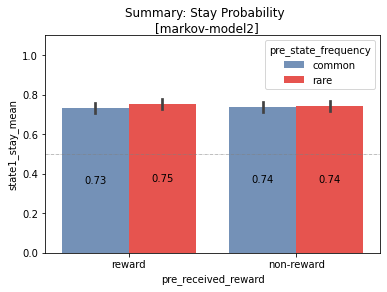

In [7]:
Plot.plot_response_switch(df=df1stay_aggregate, model_name=model_name, dep_var_suffix='_mean')

## Simulation Results: Effect

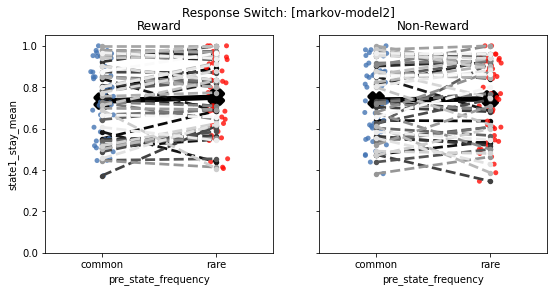

In [8]:
Plot.plot_response_switch_stripplot(df1stay_aggregate, model_name=model_name, point_hue='epoch')

## Response Time

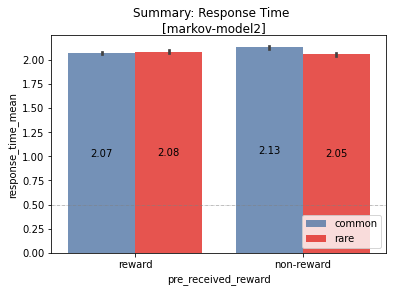

In [9]:
Plot.plot_response_time(df=df1stay_aggregate, model_name=model_name, dep_var_suffix='_mean')

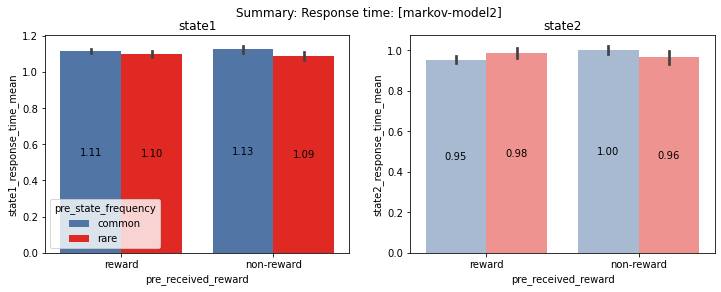

In [10]:
Plot.plot_response_time(df=df1stay_aggregate, model_name=model_name, combine=False, dep_var_suffix='_mean')

# Learning Performance

In [11]:
dfp = pd.read_csv(os.path.join(dest_dir, model_name+'-sim-logdata.csv'), index_col=0)

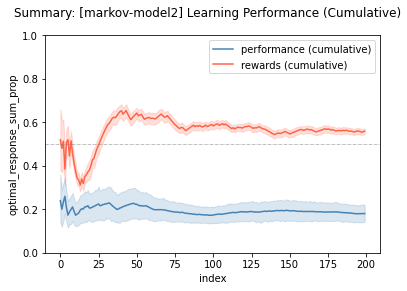

In [12]:
Plot.plot_learning_performance(dfp, title=model_name)

## ACT-R Traces



In [13]:
df1_utrace = pd.read_csv(os.path.join(dest_dir, model_name+'-actr-udata.csv'), index_col=0)

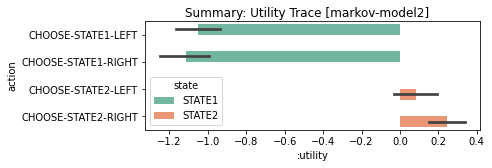

In [14]:
fig, ax = plt.subplots(figsize=(6,2))
fig.suptitle('Summary: Utility Trace [%s]' % model_name) 
sns.barplot(data=df1_utrace, y='action', x=':utility', hue='state', palette='Set2', ax=ax) 
plt.show()

## Activation Trace

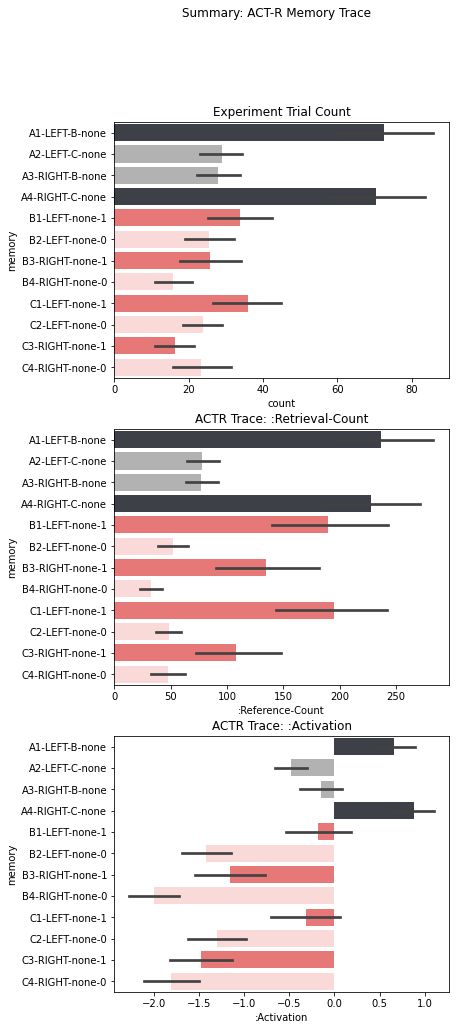

In [15]:
df1_atrace = pd.read_csv(os.path.join(dest_dir, model_name+'-actr-adata.csv'), index_col=0)
Plot.plot_activation_trace(df1_atrace)